In this example, I use the NFLfastpy library to load professional football to load Expected Pointed Added and Completion Percentage Over Expected to analyze Quarterback efficiency by passing distance. I have group passes into 3 groups: short, intermediate, and long passes. The code at the end of this sheet is designed to request an input of which distance group you would like plotted and will plot one of the 3 groups or total efficiency. 

In [1]:
#Only run this is you have no installed nflfastpy previously
#pip install nflfastpy
#pip install adjustText

In [2]:
import pandas as pd
import nflfastpy as nfl
from matplotlib import pyplot as plt
import numpy as np
from adjustText import adjust_text

/opt/anaconda3/lib/python3.9/site-packages/nflfastpy/__init__.py:16: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  default_headshot = mpl_image.imread(headshot_url)


In [3]:
df = nfl.load_pbp_data(2021)

In [4]:
df_all = df.loc[(df['pass_attempt'] == 1) & (df['air_yards'].notnull())]

df_all['passer_player_name'].replace('Aa.Rodgers','A.Rodgers',regex=True, inplace= True)
print(type(df_all))

<class 'pandas.core.frame.DataFrame'>


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [5]:
qbs = df_all.groupby(['passer_player_id','passer_player_name','posteam'],
                as_index=False).agg({'play_id':'count','epa':'mean','cpoe':'mean'})
columnsnames = ['ID','player','team','Dropbacks', 'M_Total_EPA', "M_Total_CPOE"]

qbs.columns = columnsnames
qbs = qbs.loc[qbs.Dropbacks>199]

qbs.sort_values('M_Total_EPA', ascending = False, inplace =True)
qbs = qbs.round(3)

#qbs

In [6]:
#Long passing

long = df_all.loc[(df_all['air_yards'] > 19)]

longqbs = long.groupby(['passer_player_id','passer_player_name','posteam'],
                as_index=False).agg({'play_id':'count', 'epa':'mean','cpoe':'mean'})
longcolumnsnames = ['ID','player','team','Long_passes','M_long_EPA','M_long_CPOE']
longqbs.columns = longcolumnsnames
longqbs = longqbs.loc[longqbs.Long_passes>15]

longqbs.sort_values('M_long_EPA', ascending =False, inplace=True)
longqbs = longqbs.round(3)

#longqbs

In [7]:
#mid

mid = df_all.loc[(df_all['air_yards'] > 9) & (df_all['air_yards'] < 20)]

midqbs = mid.groupby(['passer_player_id','passer_player_name','posteam'],
                as_index=False).agg({'play_id':'count', 'epa':'mean','cpoe':'mean'})
midcolumnsnames = ['ID','player','team','mid_passes','M_mid_EPA','M_mid_CPOE']
midqbs.columns = midcolumnsnames
midqbs = midqbs.loc[midqbs.mid_passes>40]

midqbs.sort_values('M_mid_EPA', ascending =False, inplace=True)
midqbs = midqbs.round(3)

#midqbs

In [8]:
#short

short = df_all.loc[(df_all['air_yards'] < 10)]

shortqbs = short.groupby(['passer_player_id','passer_player_name','posteam'],
                as_index=False).agg({'play_id':'count', 'epa':'mean','cpoe':'mean'})
shortcolumnsnames = ['ID','player','team','short_passes','M_short_EPA','M_short_CPOE']
shortqbs.columns = shortcolumnsnames

shortqbs = shortqbs.loc[shortqbs.short_passes>50]

shortqbs.sort_values('M_short_EPA', ascending =False, inplace=True)
shortqbs = shortqbs.round(3)


#shortqbs

In [9]:

big_qbdata = qbs.merge(longqbs, on = ['ID','player','team']).merge(midqbs, on = ["ID",'player','team']).merge(shortqbs, on =['ID','player','team'])
big_qbdata = big_qbdata.round(3)

#bringing in color schemes
team_logo_colors = nfl.load_team_logo_data()
big_qbdata = big_qbdata.merge(team_logo_colors[['team_abbr','team_color','team_color2']].
                              rename(columns={'team_abbr': 'team'}), on ='team')

#big_qbdata

In [10]:
#Requesting which graph is desired
while True:
    inputted_graph = input('Please enter desired passing distance (Total, Long, Intermediate, Short): ')
    if inputted_graph not in ('Total', "Long", "Intermediate", "Short"):
        print('Error: incorrect pass length entry. Please enter "Total", "Long", "Intermediate", or "Short". ')
        continue
    else:
        break
    
if inputted_graph == 'Total':
    y = big_qbdata['M_Total_EPA']
    x = big_qbdata['M_Total_CPOE']
    z = big_qbdata['Dropbacks']*2
    title = "Efficiency for all passes"
elif inputted_graph == 'Long':
    y = big_qbdata['M_long_EPA']
    x = big_qbdata['M_long_CPOE']
    z = big_qbdata['Long_passes']*5
    title = "Long Passing Efficiency (>= 20 Air Yards)"
elif inputted_graph == 'Intermediate':
    y = big_qbdata['M_mid_EPA']
    x = big_qbdata['M_mid_CPOE']
    z = big_qbdata['mid_passes']*4
    title = "Intermediate Passing Efficiency (between 10-20 Air Yards)"
elif inputted_graph == 'Short':
    y = big_qbdata['M_short_EPA']
    x = big_qbdata['M_short_CPOE']
    z = big_qbdata['short_passes']*2
    title = 'Short Passing Efficiency (<10 Air Yards)'
else:
    print('Error: incorrect pass length entry. Please enter "Total", "Long", "Intermediate", or "Short". ')

Please enter desired passing distance (Total, Long, Intermediate, Short): Long


Text(99.625, 0.5, 'EPA')

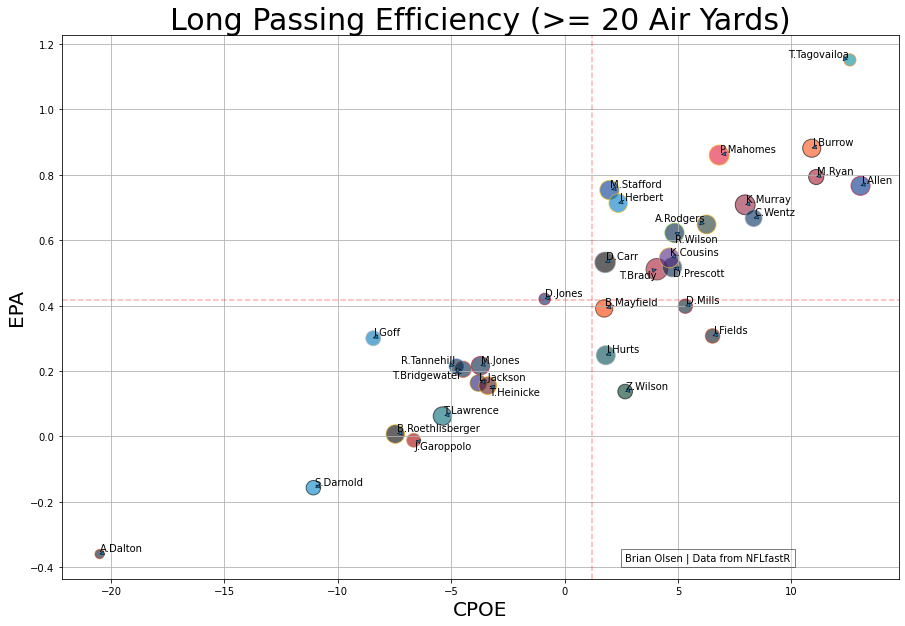

In [11]:
#Plotting
%matplotlib inline

plt.figure(figsize =(15,10))
plt.scatter(x,y,s=z, c = big_qbdata['team_color'], edgecolor = big_qbdata['team_color2'], alpha =0.6)
plt.axvline(np.mean(x), 0, color = 'red',linestyle = 'dashed',alpha =0.3)
plt.axhline(np.mean(y),0, color = 'red', linestyle = 'dashed', alpha = 0.3)

#Labels
texts =[]
for x,y,playr in zip(x,y,big_qbdata['player']):
    texts.append(plt.text(x,y,playr))
adjust_text(texts, force_text=1, arrowprops=dict(arrowstyle='-|>',lw=0.5))


plt.figtext(0.8,0.15,'Brian Olsen | Data from NFLfastR',horizontalalignment = 'right', bbox=dict(facecolor='white', alpha =0.5))
plt.grid()
plt.title(title, fontsize = 30)
plt.xlabel("CPOE", fontsize = 20)
plt.ylabel("EPA", fontsize = 20)